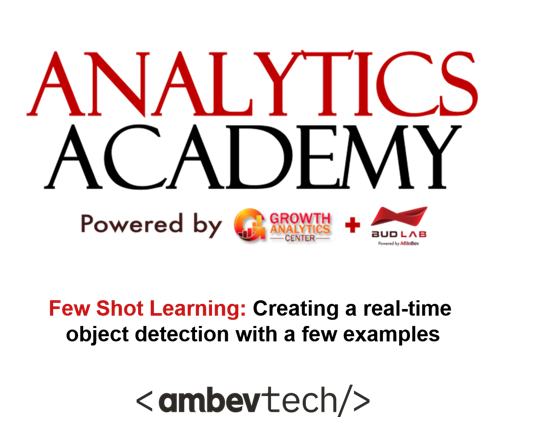

<br>
<br>
Wouldn’t it be frustrating if your smartphone needed to have thousands of pictures of you to recognize you and get unlocked? Thanks for the few-shot learning, this is not needed.

This technique has drawn a lot of attention in the research community and many solutions have been developed. To predict something based on a few training examples, the solutions right now use meta-learning or in three words: learning to learn.

If you want to learn how the few-shot detectors work, bring an object (or beer), join this Expert Class lecture, create your own object detector and run it in real-time.

<br>
Estimated time to run through this colab (with GPU): < 5 minutes.

### Imports

Importing the required packages and libraries

In [ ]:
import os
import pathlib

# Get helper functions from utils.py
if not pathlib.Path('utils.py').exists():
  !wget https://raw.githubusercontent.com/hugozanini/realtime-retinanet/main/utils.py

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

#Install JupyterPlot
pip install jupyterplot

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from jupyterplot import ProgressPlot
%matplotlib inline

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
#from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import PIL
import html
import time
import utils

### Creating the dataset

Taking pictures from your webcam to train the model 

In [ ]:
num_labels = 10
utils.create_dataset(num_labels)

### Utilities

Creating auxiliary functions

In [ ]:
def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss
  return train_step_fn

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click next image to go to the next image and submit when there are no more images.

If you'd like to skip the manual annotation step, we totally understand. In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.

In [ ]:
train_image_dir = './dataset'
train_images_np = []
for i in range(num_labels):
  image_path = os.path.join(train_image_dir, 'photo_' + str(i) + '.png')
  train_images_np.append(load_image_into_numpy_array(image_path))

In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

### Prepare date for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes). We also convert everything to the format that the training loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:
'''
By convention, our non-background classes start counting at 1.  Given
that we will be predicting just one class, we will therefore assign it a
`class id` of 1.
'''

class_id = 1
num_classes = 1
class_name = 'Skol'
category_index = {class_id: {'id': class_id, 'name': class_name}}
class_colors = {}
class_colors[class_name] = (102, 255, 51)

'''
Convert class labels to one-hot; convert everything to tensors.
The `label_id_offset` here shifts all classes by a certain number of indices;
we do this here so that the model receives one-hot labels where non-background
classes start counting at the zeroth index.  This is ordinarily just handled
automatically in our training binaries, but we need to reproduce it here.
'''

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

## Training the model

### Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

'''
Load pipeline config and build a detection model.

Since we are working off of a COCO architecture which predicts 90
class slots by default, we override the `num_classes` field here to be just
one (for our new rubber ducky class).
'''

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

'''
Set up object-based checkpoint restore --- RetinaNet has two prediction
`heads` --- one for classification, the other for box regression.  We will
restore the box regression head but initialize the classification head
from scratch (we show the omission below by commenting out the line that
we would add if we wanted to restore both heads)
'''

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

### Eager mode custom training loop

In [ ]:
tf.keras.backend.set_learning_phase(True)

'''
These parameters can be tuned; since our training set has 10 images
it doesn't make sense to have a much larger batch size, though we could
fit more examples in memory if we wanted to.
'''
batch_size = 4
learning_rate = 0.01
num_batches = 120

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
pp = ProgressPlot(plot_names=['loss'], line_names=['loss'], x_label="iteration")


for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]
  
  '''
  Note that we do not do data augmentation in this demo.  If you want a
  a fun exercise, we recommend experimenting with random horizontal flipping
  and random cropping :)
  '''

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  pp.update(float(total_loss.numpy()))

print('Done fine-tuning!')
pp.finalize()

## RetinaNet on Webcam Videos

Running RetinaNet on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our RetinaNet model and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream. 


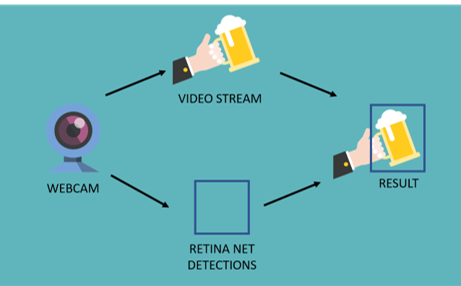

In [ ]:
# start streaming video from webcam
utils.video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = utils.video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = utils.js_to_image(js_reply["img"])
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, axis=0), dtype=tf.float32)
    detections = detect(input_tensor)

    image_np_with_annotations = np.zeros([480,640,3], dtype=np.uint8).copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) 
        + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    bbox_array[:,:,3] = \
              (image_np_with_annotations.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

## References


[0] Lin, Tsung-Yi, et al. "Focal loss for dense object detection." Proceedings of the IEEE international conference on computer vision. 2017.

---

[1] Rathod, Vivek, and Kmindspark. “Eager Few Shot Object Detection Colab.” GitHub, Tensorflow, 11 July 2020, [github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb). 

---

[2] Tsang, Sik-Ho. “Review: RetinaNet - Focal Loss (Object Detection).” Medium, Towards Data Science, 26 Mar. 2019, towardsdatascience.com/review-retinanet-focal-loss-object-detection-38fba6afabe4. 

---

[3] Humbarwadi, rihari. “Keras Documentation: Object Detection with RetinaNet.” Keras, 17 May 2020, [keras.io/examples/vision/retinanet/](https://keras.io/examples/vision/retinanet/). 


---

